In [1]:
import jax.numpy as jnp
import bayes3d as b
import numpy as np
import bayes3d.utils.ycb_loader
import trimesh
import jax
import os
from tqdm import tqdm


GenJAX not installed. Importing bayes3d without genjax dependencies.


In [5]:
import os

import matplotlib.pyplot as plt
import torch
from PIL import Image

from f3rm.features.clip_extract import extract_clip_features
from f3rm.features.dino_extract import extract_dino_features
from f3rm.pca_colormap import apply_pca_colormap

In [23]:
rgbds = []
images = []
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
for scene_id in [1,21,34]:
    rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('52', f'{scene_id}', bop_ycb_dir)
    full_mask = (jnp.stack(masks).sum(0) > 0)
    images.append(b.get_rgb_image(rgbd.rgb * full_mask[..., None]))

In [24]:
image_paths = []
for i in range(len(images)):
    name = f'img_{i}.png'
    image_paths.append(name)
    images[i].save(name)
print(image_paths)

['img_0.png', 'img_1.png', 'img_2.png']


Loaded CLIP model ViT-L/14@336px
Skipping center crop
Preprocessed 3 images into torch.Size([3, 3, 336, 448])


Extracting CLIP features: 100%|██████████| 1/1 [00:00<00:00, 42.47it/s]

Extracted CLIP embeddings of shape torch.Size([3, 24, 32, 768])



Using cache found in /home/nishadgothoskar/.cache/torch/hub/facebookresearch_dino_main


Loaded DINO model dino_vits8
Preprocessed 3 images to shape torch.Size([3, 3, 224, 298])


Extracting DINO features: 100%|██████████| 1/1 [00:00<00:00, 76.54it/s]

Extracted DINO embeddings of shape torch.Size([3, 55, 73, 384])


Saved plot to demo_extract_features.png


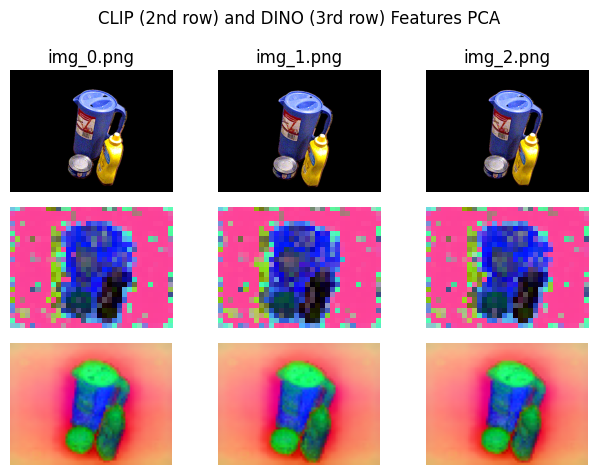

In [25]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

clip_embeddings = extract_clip_features(image_paths, device)
# Convert to float as torch PCA doesn't support half on GPU
clip_embeddings = clip_embeddings.float()
clip_pca = apply_pca_colormap(clip_embeddings).cpu().numpy()

dino_embeddings = extract_dino_features(image_paths, device)
dino_pca = apply_pca_colormap(dino_embeddings).cpu().numpy()

# Visualize the embeddings
plt.figure()
plt.suptitle("CLIP (2nd row) and DINO (3rd row) Features PCA")
for i, (image_path, clip_pca_, dino_pca_) in enumerate(zip(image_paths, clip_pca, dino_pca)):
    plt.subplot(3, len(image_paths), i + 1)
    plt.imshow(Image.open(image_path))
    plt.title(os.path.basename(image_path))
    plt.axis("off")

    plt.subplot(3, len(image_paths), len(image_paths) + i + 1)
    plt.imshow(clip_pca_)
    plt.axis("off")

    plt.subplot(3, len(image_paths), 2 * len(image_paths) + i + 1)
    plt.imshow(dino_pca_)
    plt.axis("off")

plt.tight_layout()
plt.savefig("demo_extract_features.png")
print("Saved plot to demo_extract_features.png")
plt.show()


In [26]:
dino_pca.shape

(3, 55, 73, 3)

In [ ]:
%matplotlib widget
IDX1 = 70
img1 = images[IDX1].rgb
img1_resized = images[IDX1].scale_rgbd(1.0/14.0).rgb

def onclick(event):
    print("hello")
    # cos = nn.CosineSimilarity(dim=1)

    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))
    x2, y2 = int(np.round(event.xdata / 14.0)), int(np.round(event.ydata / 14.0))
    data.append((x,y))

    target_embedding = img1_embedding[y2, x2,:]

    # dot_products = jnp.einsum("i, abi->ab", target_embedding, img2_embedding)

    heatmap = get_heatmap(target_embedding, img2_embedding)
    scaled_up_heatmap = b.utils.resize(heatmap, img2.shape[0], img2.shape[1])

    axes[0].clear()
    axes[1].clear()
    axes[0].imshow(img1 /255.0)
    axes[1].imshow(img2 / 255.0)
    axes[0].scatter(x, y, c='r', s=10.0)

    max_yx = np.unravel_index(scaled_up_heatmap.argmax(), scaled_up_heatmap.shape)
    # axes[1].axis('off')
    axes[1].imshow(255 * scaled_up_heatmap, alpha=0.45, cmap='viridis')
    # axes[1].axis('off')
    axes[1].scatter(max_yx[1], max_yx[0], c='r', s=10)
    # axes[1].set_title('target image')
    # gc.collect()

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [10]:
dino_embeddings.shape

torch.Size([3, 55, 73, 384])